# Max Precipitation Temporal Skill

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import r2_score

In [2]:
#set the base path 
base_path = '/sfs/weka/scratch/zkq5md/models/final'

#load the pred csvs
df_trivial = pd.read_csv(f'{base_path}/brute/preds.csv', index_col='Unnamed: 0')
df_loss = pd.read_csv(f'{base_path}/loss/preds.csv', index_col='Unnamed: 0')
df_loss2 = pd.read_csv(f'{base_path}/loss2/preds.csv', index_col='Unnamed: 0')
df_line = pd.read_csv(f'{base_path}/linear/preds.csv', index_col='Unnamed: 0')
df_line2 = pd.read_csv(f'{base_path}/linear2/preds.csv', index_col='Unnamed: 0')
df_post2 = pd.read_csv(f'{base_path}/post2/preds.csv', index_col='Unnamed: 0')

In [3]:
#load the testing csv
df = pd.read_csv(f'{base_path[:-13]}/Data/final/SE_mem_precip_data.csv', index_col='Unnamed: 0')
df_test=df[(df['Member'].isin([17, 18]))].copy()
df_test.reset_index(drop=True, inplace=True)

columns_to_analyze = ['y_pred1', 'y_pred2', 'y_pred3', 'y_pred4', 'y_pred5', 'y_pred6', 'y_pred7', 'y_pred8', 'y_pred9', 'y_pred10']
quants = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

In [4]:
def complex_method(df_cur, df_test):
    '''
    A definition that generates results for the temporal skill of the CNNs.
    
    df_cur = the dataframe that is being tested
    df_test = the testing dataframe
    
    '''
    
    #join the dataframe with the testing dataframe
    join = df_cur.join(df_test, how='inner')
    join['Datetimes'] = pd.to_datetime(join['Datetimes'])
    
    #set vars
    columns_to_analyze = ['y_pred1', 'y_pred2', 'y_pred3', 'y_pred4', 'y_pred5', 'y_pred6', 'y_pred7', 'y_pred8', 'y_pred9', 'y_pred10']
    quants = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

    #create pandas df
    df = pd.DataFrame({'quants': quants})
    
    #iterate through the quantiles
    for col in columns_to_analyze:
        temp = []
        print(col)

        for quant in quants:
            df1 = join.nlargest(int(len(join)*quant), 'Y_max_test').sort_index()
            val = []

            for rid, row in df1.iterrows():
                start_date = row.Datetimes - pd.Timedelta(days=5)
                end_date = row.Datetimes + pd.Timedelta(days=5)

                df_work = join[(join['Datetimes'] >= start_date) & (join['Datetimes'] <= end_date)].copy()
                df_work = df_work[(df_work['Member'] == row.Member)].copy()

                val_idx = np.where(df_work['Y_max_test'].values == row.Y_max_test)[0][0]

                if val_idx in np.where(df_work[col].values >= 0.8*row.Y_max_test)[0]:
                    val.append(0)

                else:
                    val.append(np.where(df_work[col].values == np.max(df_work[col].values))[0][0]-val_idx)

            temp.append(np.sum(np.mean(np.absolute(val))))

        df[col] = temp

    return df

    

In [5]:
def simple_method(df_cur, df_test):
    '''
    A definition that generates results for the temporal skill of the CNNs.
    
    df_cur = the dataframe that is being tested
    df_test = the testing dataframe
    
    '''
    
    #set vars
    quants = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

    #create pandas df
    df = pd.DataFrame({'quants': quants})

    #iterate through the quantiles
    for col in columns_to_analyze:
        temp = []

        for quant in quants:
            df1 = df_cur.nlargest(int(len(df_cur)*quant), 'Y_max_test').sort_index()
            df2 = df_cur.nlargest(int(len(df_cur)*quant), col).sort_index()
            temp.append(np.mean(np.mean(np.absolute(df1.index.values - df2.index.values))))

        df[col] = temp
        
    return

## Trivial Performance

In [6]:
trivial = complex_method(df_trivial, df_test)

mean_trivial = trivial[columns_to_analyze].mean(axis=1).values
mini_trivial = trivial[columns_to_analyze].min(axis=1).values
maxi_trivial = trivial[columns_to_analyze].max(axis=1).values

y_pred1
y_pred2
y_pred3
y_pred4
y_pred5
y_pred6
y_pred7
y_pred8
y_pred9
y_pred10


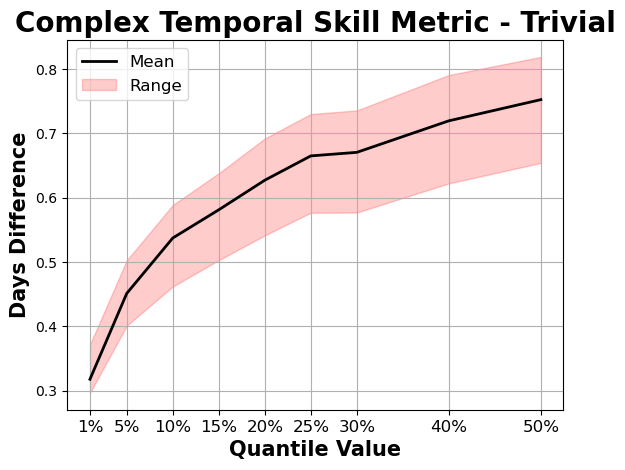

In [7]:
plt.plot(quants, mean_trivial, color = 'k', lw=2)
plt.fill_between(quants, y1 = mini_trivial, y2 = maxi_trivial, color = 'red', alpha=0.2)

plt.xlabel('Quantile Value', fontsize=15).set_weight('bold')
plt.ylabel('Days Difference', fontsize=15).set_weight('bold')
plt.xticks(quants, [x + '%' for x in map(str, (np.array(quants)*100).astype(int))], fontsize=12)

plt.legend(['Mean','Range'], fontsize=12)
plt.title('Complex Temporal Skill Metric - Trivial', fontsize=20).set_weight('bold')

plt.grid()

## Absolute Error Loss Function

In [8]:
abs_loss = complex_method(df_loss, df_test)

mean_abs_loss = abs_loss[columns_to_analyze].mean(axis=1).values
mini_abs_loss = abs_loss[columns_to_analyze].min(axis=1).values
maxi_abs_loss = abs_loss[columns_to_analyze].max(axis=1).values

y_pred1
y_pred2
y_pred3
y_pred4
y_pred5
y_pred6
y_pred7
y_pred8
y_pred9
y_pred10


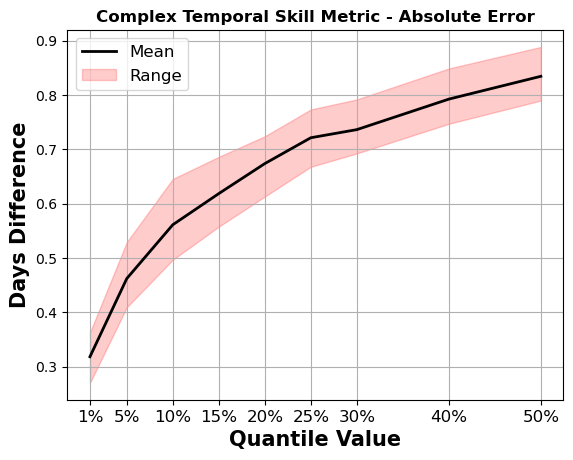

In [9]:
plt.plot(quants, mean_abs_loss, color = 'k', lw=2)
plt.fill_between(quants, y1 = mini_abs_loss, y2 = maxi_abs_loss, color = 'red', alpha=0.2)

plt.xlabel('Quantile Value', fontsize=15).set_weight('bold')
plt.ylabel('Days Difference', fontsize=15).set_weight('bold')
plt.xticks(quants, [x + '%' for x in map(str, (np.array(quants)*100).astype(int))], fontsize=12)

plt.legend(['Mean','Range'], fontsize=12)
plt.title('Complex Temporal Skill Metric - Absolute Error', fontsize=12).set_weight('bold')

plt.grid()

## MSE Loss Function

In [10]:
mse_loss = complex_method(df_loss2, df_test)

mean_mse_loss = mse_loss[columns_to_analyze].mean(axis=1).values
mini_mse_loss = mse_loss[columns_to_analyze].min(axis=1).values
maxi_mse_loss = mse_loss[columns_to_analyze].max(axis=1).values

y_pred1
y_pred2
y_pred3
y_pred4
y_pred5
y_pred6
y_pred7
y_pred8
y_pred9
y_pred10


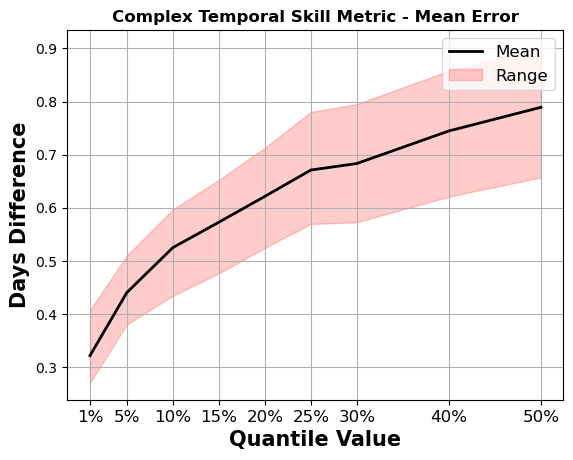

In [11]:
plt.plot(quants, mean_mse_loss, color = 'k', lw=2)
plt.fill_between(quants, y1 = mini_mse_loss, y2 = maxi_mse_loss, color = 'red', alpha=0.2)

plt.xlabel('Quantile Value', fontsize=15).set_weight('bold')
plt.ylabel('Days Difference', fontsize=15).set_weight('bold')
plt.xticks(quants, [x + '%' for x in map(str, (np.array(quants)*100).astype(int))], fontsize=12)

plt.legend(['Mean','Range'], fontsize=12)
plt.title('Complex Temporal Skill Metric - Mean Error', fontsize=12).set_weight('bold')

plt.grid()

## Simple Linear Model

In [12]:
line = complex_method(df_line, df_test)

mean_line = line[columns_to_analyze].mean(axis=1).values
mini_line = line[columns_to_analyze].min(axis=1).values
maxi_line = line[columns_to_analyze].max(axis=1).values

y_pred1
y_pred2
y_pred3
y_pred4
y_pred5
y_pred6
y_pred7
y_pred8
y_pred9
y_pred10


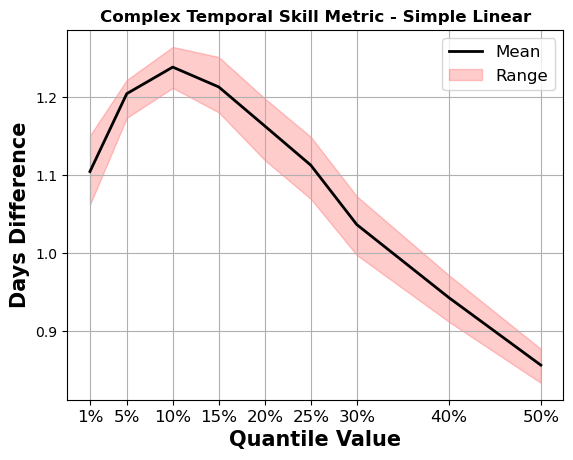

In [13]:
plt.plot(quants, mean_line, color = 'k', lw=2)
plt.fill_between(quants, y1 = mini_line, y2 = maxi_line, color = 'red', alpha=0.2)

plt.xlabel('Quantile Value', fontsize=15).set_weight('bold')
plt.ylabel('Days Difference', fontsize=15).set_weight('bold')
plt.xticks(quants, [x + '%' for x in map(str, (np.array(quants)*100).astype(int))], fontsize=12)

plt.legend(['Mean','Range'], fontsize=12)
plt.title('Complex Temporal Skill Metric - Simple Linear', fontsize=12).set_weight('bold')

plt.grid()

## Smart Linear

In [14]:
line2 = complex_method(df_line2, df_test)

mean_line2 = line2[columns_to_analyze].mean(axis=1).values
mini_line2 = line2[columns_to_analyze].min(axis=1).values
maxi_line2 = line2[columns_to_analyze].max(axis=1).values

y_pred1
y_pred2
y_pred3
y_pred4
y_pred5
y_pred6
y_pred7
y_pred8
y_pred9
y_pred10


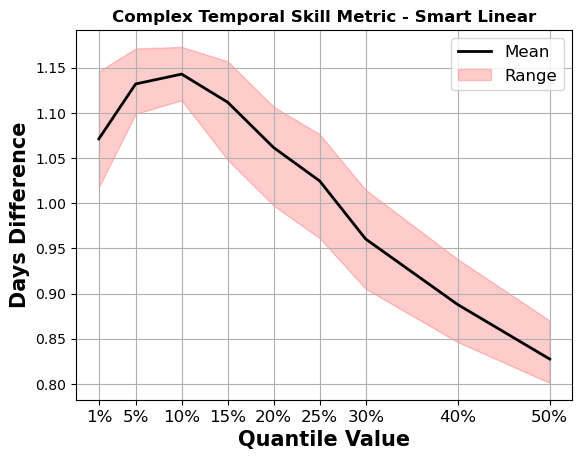

In [15]:
plt.plot(quants, mean_line2, color = 'k', lw=2)
plt.fill_between(quants, y1 = mini_line2, y2 = maxi_line2, color = 'red', alpha=0.2)

plt.xlabel('Quantile Value', fontsize=15).set_weight('bold')
plt.ylabel('Days Difference', fontsize=15).set_weight('bold')
plt.xticks(quants, [x + '%' for x in map(str, (np.array(quants)*100).astype(int))], fontsize=12)

plt.legend(['Mean','Range'], fontsize=12)
plt.title('Complex Temporal Skill Metric - Smart Linear', fontsize=12).set_weight('bold')

plt.grid()

## Fine Tune

In [16]:
post2 = complex_method(df_post2, df_test)

mean_post2 = post2[columns_to_analyze].mean(axis=1).values
mini_post2 = post2[columns_to_analyze].min(axis=1).values
maxi_post2 = post2[columns_to_analyze].max(axis=1).values

y_pred1
y_pred2
y_pred3
y_pred4
y_pred5
y_pred6
y_pred7
y_pred8
y_pred9
y_pred10


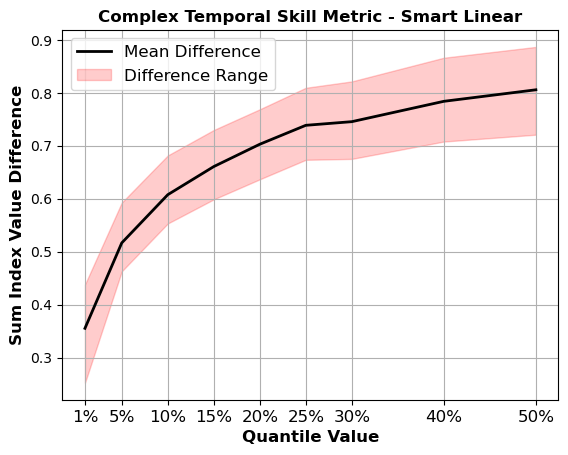

In [17]:
plt.plot(quants, mean_post2, color = 'k', lw=2)
plt.fill_between(quants, y1 = mini_post2, y2 = maxi_post2, color = 'red', alpha=0.2)

plt.xlabel('Quantile Value', fontsize=12).set_weight('bold')
plt.ylabel('Sum Index Value Difference', fontsize=12).set_weight('bold')
plt.xticks(quants, [x + '%' for x in map(str, (np.array(quants)*100).astype(int))], fontsize=12)

plt.legend(['Mean Difference','Difference Range'], fontsize=12)
plt.title('Complex Temporal Skill Metric - Smart Linear', fontsize=12).set_weight('bold')

plt.grid()

## Model Comparison

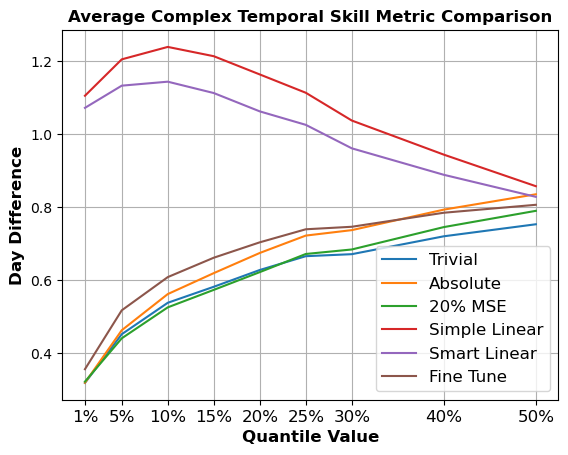

In [18]:
for data in [trivial, abs_loss, mse_loss, line, line2, post2]:
    mean = data[columns_to_analyze].mean(axis=1).values
    plt.plot(quants, mean, lw=1.5)

plt.xlabel('Quantile Value', fontsize=12).set_weight('bold')
plt.ylabel('Day Difference', fontsize=12).set_weight('bold')
plt.xticks(quants, [x + '%' for x in map(str, (np.array(quants)*100).astype(int))], fontsize=12)

plt.legend(['Trivial','Absolute', '20% MSE', 'Simple Linear', 'Smart Linear', 'Fine Tune'], fontsize=12)
plt.title('Average Complex Temporal Skill Metric Comparison', fontsize=12).set_weight('bold')

plt.grid()

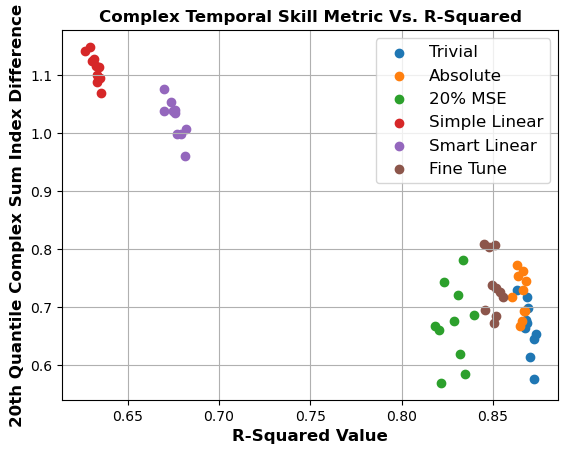

In [19]:
y_true = df_trivial['Y_max_test'].values
dfs = ['trivial', 'loss', 'loss2', 'line', 'line2', 'post2']

for num, method in enumerate(['trivial', 'abs_loss', 'mse_loss', 'line', 'line2', 'post2']):
    temp=[]
    rs =[]
    
    for col in columns_to_analyze:
        temp.append(locals()[f'{method}'][col].values[5])
        rs.append(r2_score(y_true, locals()[f'df_{dfs[num]}'][col].values))
        
    plt.scatter(rs, temp)

plt.legend(['Trivial','Absolute', '20% MSE', 'Simple Linear', 'Smart Linear', 'Fine Tune'], fontsize=12)
plt.title('Complex Temporal Skill Metric Vs. R-Squared', fontsize=12).set_weight('bold')
plt.xlabel('R-Squared Value', fontsize=12).set_weight('bold')
plt.ylabel('20th Quantile Complex Sum Index Difference', fontsize=12).set_weight('bold')

plt.grid()

/tmp/ipykernel_808306/695251532.py:9: UserWarning: p-value floored: true value smaller than 0.001
  ad.append(stats.anderson_ksamp([y_true, locals()[f'df_{dfs[num]}'][col].values]).statistic)


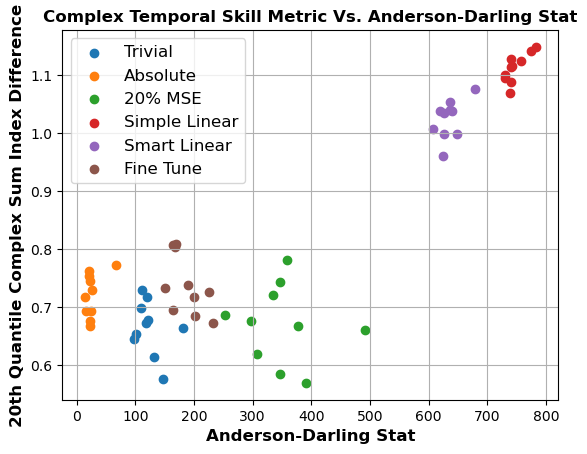

In [20]:
y_true = df_trivial['Y_max_test'].values

for num, method in enumerate(['trivial', 'abs_loss', 'mse_loss', 'line', 'line2', 'post2']):
    temp=[]
    ad =[]
    
    for col in columns_to_analyze:
        temp.append(locals()[f'{method}'][col].values[5])
        ad.append(stats.anderson_ksamp([y_true, locals()[f'df_{dfs[num]}'][col].values]).statistic)
        
    plt.scatter(ad, temp)

plt.legend(['Trivial','Absolute', '20% MSE', 'Simple Linear', 'Smart Linear', 'Fine Tune'], fontsize=12)
plt.title('Complex Temporal Skill Metric Vs. Anderson-Darling Stat', fontsize=12).set_weight('bold')
plt.xlabel('Anderson-Darling Stat', fontsize=12).set_weight('bold')
plt.ylabel('20th Quantile Complex Sum Index Difference', fontsize=12).set_weight('bold')

plt.grid()

/tmp/ipykernel_808306/2101288348.py:9: UserWarning: p-value floored: true value smaller than 0.001
  ad.append(stats.anderson_ksamp([y_true, locals()[f'df_{dfs[num]}'][col].values]).statistic)
/tmp/ipykernel_808306/2101288348.py:9: UserWarning: p-value floored: true value smaller than 0.001
  ad.append(stats.anderson_ksamp([y_true, locals()[f'df_{dfs[num]}'][col].values]).statistic)
/tmp/ipykernel_808306/2101288348.py:9: UserWarning: p-value floored: true value smaller than 0.001
  ad.append(stats.anderson_ksamp([y_true, locals()[f'df_{dfs[num]}'][col].values]).statistic)
/tmp/ipykernel_808306/2101288348.py:9: UserWarning: p-value floored: true value smaller than 0.001
  ad.append(stats.anderson_ksamp([y_true, locals()[f'df_{dfs[num]}'][col].values]).statistic)
/tmp/ipykernel_808306/2101288348.py:9: UserWarning: p-value floored: true value smaller than 0.001
  ad.append(stats.anderson_ksamp([y_true, locals()[f'df_{dfs[num]}'][col].values]).statistic)
/tmp/ipykernel_808306/2101288348.py

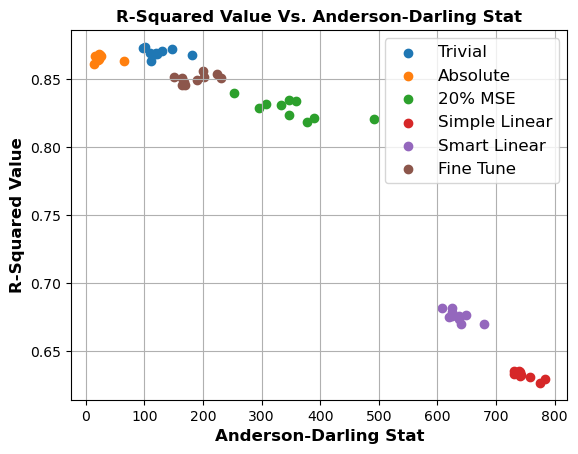

In [21]:
y_true = df_trivial['Y_max_test'].values

for num, method in enumerate(['trivial', 'loss', 'loss2', 'line', 'line2', 'post2']):
    rs=[]
    ad =[]
    
    for col in columns_to_analyze:
        rs.append(r2_score(y_true, locals()[f'df_{dfs[num]}'][col].values))
        ad.append(stats.anderson_ksamp([y_true, locals()[f'df_{dfs[num]}'][col].values]).statistic)
        
    plt.scatter(ad, rs)

plt.legend(['Trivial','Absolute', '20% MSE', 'Simple Linear', 'Smart Linear', 'Fine Tune'], fontsize=12)
plt.title('R-Squared Value Vs. Anderson-Darling Stat', fontsize=12).set_weight('bold')
plt.xlabel('Anderson-Darling Stat', fontsize=12).set_weight('bold')
plt.ylabel('R-Squared Value', fontsize=12).set_weight('bold')

plt.grid()